# Downloading and plotting GOES-R imagery with goespy and xarray

[Steven Pestana](https://spestana.github.io/), January 2021

This notebook walks through the steps for using [goespy](https://github.com/palexandremello/goes-py) to download GOES-R imagery. Then we use xarray to read the images into python. Finally we will create an RGB image from three ABI bands roughly following [this example by Danielle Losos](https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances).

---

Import the packages we'll need. We will use the xarray package and the ABI_Downloader function from goespy for working with and downloading GOES imagery respectively.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
from goespy.Downloader import ABI_Downloader


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


---

### Downloading GOES ABI-L1b-Rad products from AWS with goespy

First, we will download the CONUS radiance (ABI-L1b-Rad) products from GOES-16 and GOES-17 for one specific date and hour (date and times in UTC). (ABI_Downloader will download all images taken within the hour we provide)

In [2]:
destination_path = './example/' # I have a folder named "example" where I am downloading the ABI imagery to
bucket = 'noaa-goes16'
year = '2020'
month = '03'
day = '03'
hour = '19'
product = 'ABI-L1b-RadC'
channel = ['C01', 'C02', 'C03']

Download the GOES-16 imagery from AWS:

In [3]:
ABI_Downloader(destination_path, bucket, year, month, day, hour, product, channel)

Downloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M6C03_G16_s20200631956138_e20200631958511_c20200631958576.nc: [##########] 100%  16.249844 MB/16.249844 MB

0

And again for GOES-17:

In [4]:
bucket = 'noaa-goes17'

In [5]:
ABI_Downloader(destination_path, bucket, year, month, day, hour, product, channel)

Downloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M6C03_G17_s20200631956176_e20200631958549_c20200631958586.nc: [##########] 100%  17.802478 MB/17.802478 MB

0

---
### Create RGB images

From the ABI imagery we just downloaded, let's create RGB images for the GOES-16 and GOES-17 views of CONUS. First, find all the files we just downloaded using glob.

In [6]:
# GOES-16 files
goes_16_C01_files = glob.glob('{destination_path}{bucket}/{year}/{month}/{day}/{product}/{hour}/{channel}/*'.format(
                    destination_path=destination_path,
                    bucket='goes16', # note that there's no hyphen in the file path name of the bucket
                    year=year,
                    month=month,
                    day=day,
                    product=product,
                    hour=hour,
                    channel='C01')
                  )
goes_16_C02_files = glob.glob('{destination_path}{bucket}/{year}/{month}/{day}/{product}/{hour}/{channel}/*'.format(
                    destination_path=destination_path,
                    bucket='goes16', # note that there's no hyphen in the file path name of the bucket
                    year=year,
                    month=month,
                    day=day,
                    product=product,
                    hour=hour,
                    channel='C02')
                  )
goes_16_C03_files = glob.glob('{destination_path}{bucket}/{year}/{month}/{day}/{product}/{hour}/{channel}/*'.format(
                    destination_path=destination_path,
                    bucket='goes16', # note that there's no hyphen in the file path name of the bucket
                    year=year,
                    month=month,
                    day=day,
                    product=product,
                    hour=hour,
                    channel='C03')
                  )

# GOES-17 files
goes_17_C01_files = glob.glob('{destination_path}{bucket}/{year}/{month}/{day}/{product}/{hour}/{channel}/*'.format(
                    destination_path=destination_path,
                    bucket='goes17', # note that there's no hyphen in the file path name of the bucket
                    year=year,
                    month=month,
                    day=day,
                    product=product,
                    hour=hour,
                    channel='C01')
                  )
goes_17_C02_files = glob.glob('{destination_path}{bucket}/{year}/{month}/{day}/{product}/{hour}/{channel}/*'.format(
                    destination_path=destination_path,
                    bucket='goes17', # note that there's no hyphen in the file path name of the bucket
                    year=year,
                    month=month,
                    day=day,
                    product=product,
                    hour=hour,
                    channel='C02')
                  )
goes_17_C03_files = glob.glob('{destination_path}{bucket}/{year}/{month}/{day}/{product}/{hour}/{channel}/*'.format(
                    destination_path=destination_path,
                    bucket='goes17', # note that there's no hyphen in the file path name of the bucket
                    year=year,
                    month=month,
                    day=day,
                    product=product,
                    hour=hour,
                    channel='C03')
                  )

To read the NetCDF files, we'll use xarray. I'll just pick the first one from each channel/band for the year, month, day, hour we downloaded.

In [7]:
# GOES-16
goes_16_C01 = xr.open_dataset(goes_16_C01_files[0])
goes_16_C02 = xr.open_dataset(goes_16_C02_files[0])
goes_16_C03 = xr.open_dataset(goes_16_C03_files[0])

# GOES-17
goes_17_C01 = xr.open_dataset(goes_17_C01_files[0])
goes_17_C02 = xr.open_dataset(goes_17_C02_files[0])
goes_17_C03 = xr.open_dataset(goes_17_C03_files[0])

Plot the NIR band (channel C03) radiances from both GOES-16 and GOES-17 to check if data loaded correctly:

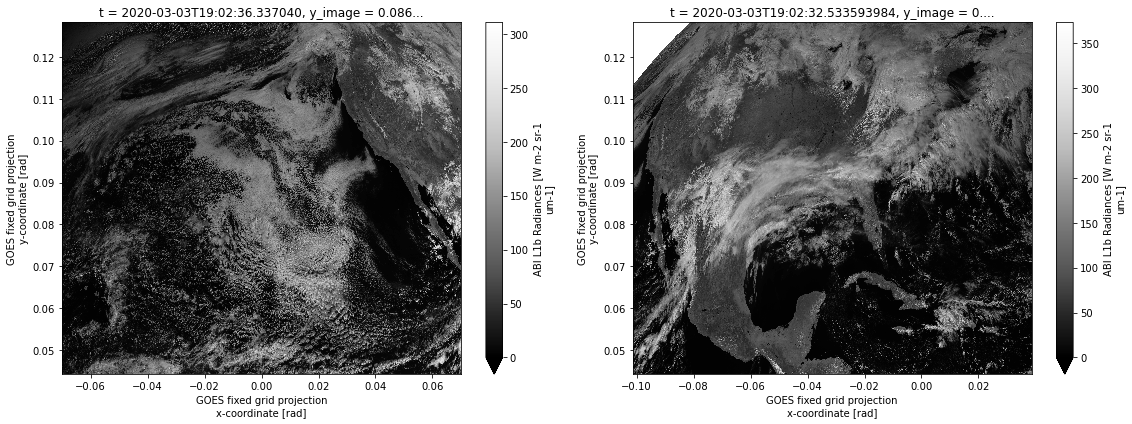

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,6), tight_layout=True)

# GOES-16
goes_16_C03.Rad.plot(ax=ax2, cmap='Greys_r', vmin=0)

# GOES-17
goes_17_C03.Rad.plot(ax=ax1, cmap='Greys_r', vmin=0)

Define functions adapted from [this example code by Danielle Losos](https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances) to create RGB images.

In [9]:
# Define the rebin function
def rebin(a, shape):
    ''' Rebin function that will be used to resample the band resolution
        Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
    '''
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

def makeABIrgb(R,G,B):
    ''' Create RGB images given GOES-R ABI Channel 01, 02, and 03 datasets.
        Adapted from https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances
        
        returns:
                RGB: "True Color" RGB
                RGB_veggie: "False Color" RGB
    '''

    ### Convert radiance to reflectance
    
    # Get the kappa coefficients for each band
    kappa_B = B['kappa0'].data
    kappa_R = R['kappa0'].data
    kappa_G = G['kappa0'].data

    #To convert radiance to reflectance, use formula:
    #reflectance (ρf(υ)) = kappa factor(κ) * radiance (L(ν))
    #Source: GOES-R Series Product Definition and User Guide (PUG) Volume 3, Revision 2.2, pages 27-28
    R_ref = kappa_R * R['Rad'].data
    G_ref = kappa_G * G['Rad'].data 
    B_ref = kappa_B * B['Rad'].data
    
    # Apply range limits for each channel. Reflectance values must be between 0 and 1.
    R_ref = np.clip(R_ref, 0, 1)
    G_ref = np.clip(G_ref, 0, 1)
    B_ref = np.clip(B_ref, 0, 1)

    # Apply a gamma correction to the image to correct ABI detector brightness
    gamma = 2.2
    Red = np.power(R_ref, 1/gamma)
    Green = np.power(G_ref, 1/gamma)
    Blue = np.power(B_ref, 1/gamma)

    #Resample the Red Band resolution
    Red_rescaled = rebin(Red, [3000, 5000])

    # GOES-R Series satellites do not have a channel in the visible green range. Band 3 is a NIR channel typically used to monitor vegetation.
    # Calculate the "True" Green Band to serve as a green proxy for the RGB True Color image, using a fractional combination.
    # Source: "Generation of GOES‐16 True Color Imagery without a Green Band" - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018EA000379
    Green_true = 0.45 * Red_rescaled + 0.1 * Green + 0.45 * Blue
    Green_true = np.clip(Green_true, 0, 1)  # Apply band limits again, just in case.

    # Combine three RGB channels with a stacked array, then display the resulting images.

    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([Red_rescaled, Green, Blue])
    
    # The RGB array for the true color image
    RGB = np.dstack([Red_rescaled, Green_true, Blue])
    
    return RGB, RGB_veggie

Create RGB Images for GOES-16 and GOES-17 with this function:

In [10]:
# GOES-16
goes16_RGB, goes16_RGB_veggie = makeABIrgb(goes_16_C02, goes_16_C03, goes_16_C01)

In [11]:
# GOES-17
goes17_RGB, goes17_RGB_veggie = makeABIrgb(goes_17_C02, goes_17_C03, goes_17_C01)

Plot the resulting images:

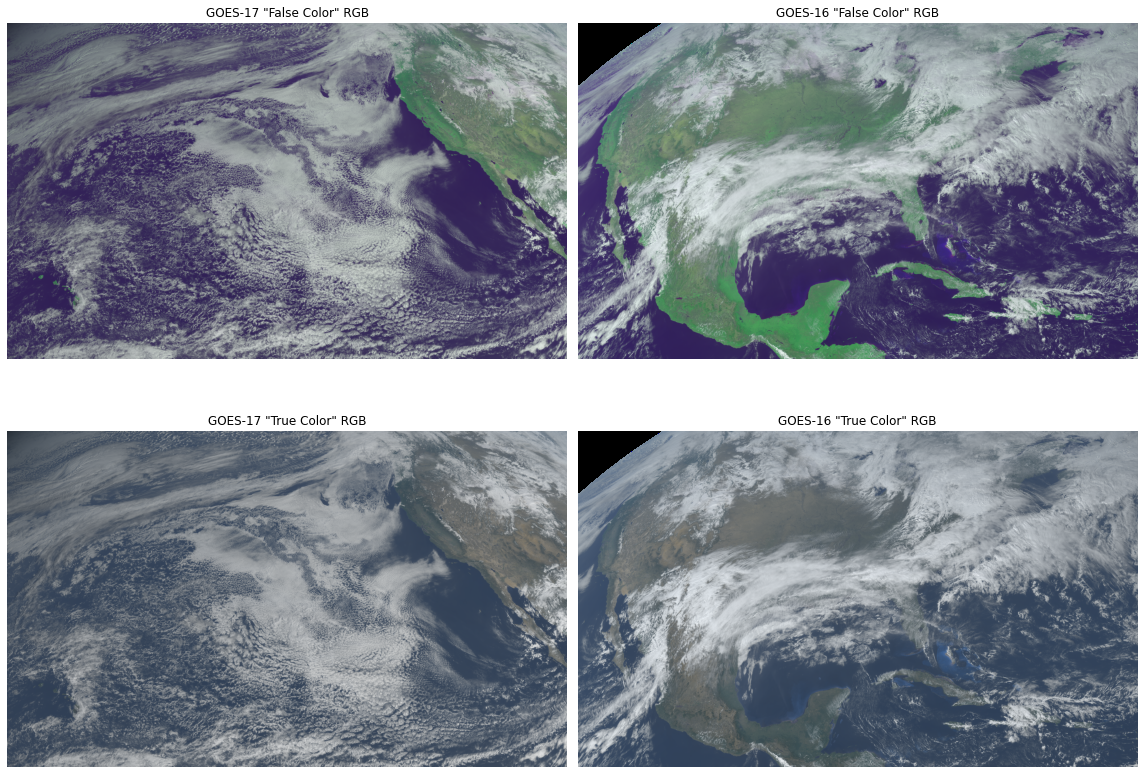

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)
[ax1, ax2, ax3, ax4] = ax.flatten()

# GOES-17 False Color: RGB using the NIR "Veggie" Band
ax1.imshow(goes17_RGB_veggie)
ax1.set_title('GOES-17 "False Color" RGB')
ax1.axis('off')

# GOES-16 False Color: RGB using the NIR "Veggie" Band
ax2.imshow(goes16_RGB_veggie)
ax2.set_title('GOES-16 "False Color" RGB')
ax2.axis('off')

# GOES-17 True Color: RGB for the true color image
ax3.imshow(goes17_RGB)
ax3.set_title('GOES-17 "True Color" RGB')
ax3.axis('off')

# GOES-16 True Color: RGB for the true color image
ax4.imshow(goes16_RGB)
ax4.set_title('GOES-16 "True Color" RGB')
ax4.axis('off');